# Exploring how the 2-layer model with a temperature dependent gamma behaves

Let's look at some of the familiar idealized forcing scenarios to see if the model still works when the temp. difference goes negative. Basically, let's perform a sanity check.

So plan:
1.   positive followed by negative triangular forcing
1.   top hat forcing of widths 5,50,200 years 

--SHO behaviour investigation--

--Kappa range investigation --

3.   triangular forcing of widths 5,50,200 years  => I think this isn't really necessary. SKIP
4.   oscillatory tophat forcing of widths 5,50,200 years (adjust so same wavelength as pulsed forcing )
5.   oscillatory triangular forcing of widths 5,50,200 years (adjust so same wavelength as pulsed forcing)

We also want to see whether we can reproduce Bouttes' asymmetry investigation/

Then we will test a range of kappas -> Important!


In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

### 1)Positive followed by negative triangular forcing, compare with meeting notes
Right now we are simply using kappa = 0.3. This was the biggest kappa possible before gamma became negative. We will have to test a range later. But this large value is good for making the effects of kappa obvious.
For this we will have a wavelength of 200 years. Amplitude of 4xCO2 See signal below.


In [3]:
runs = {}

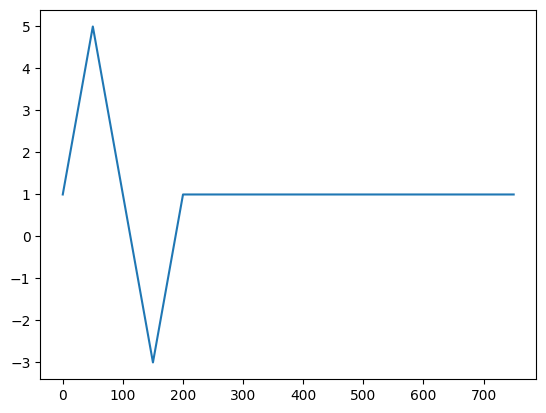

In [4]:

xs = np.arange(751) 
xs = xs * 4/50

xs[50:151] = xs[50:151]* -1

xs[50:151] = xs[50:151] + 8 
xs[151:201] = xs[151:201] - 16
xs += 1
xs[200:] = 1

triang_pulse = xs
plt.plot(xs)
#need to run cell above
steps = [triang_pulse]
step_names = ["Triangular Pulse"]

In [4]:
for (step, name) in zip(steps, step_names):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= step,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            kappa=0.3, 
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    runs[name] = out

currently on Triangular Pulse... 


100%|██████████| 1000/1000 [00:22<00:00, 43.73it/s]


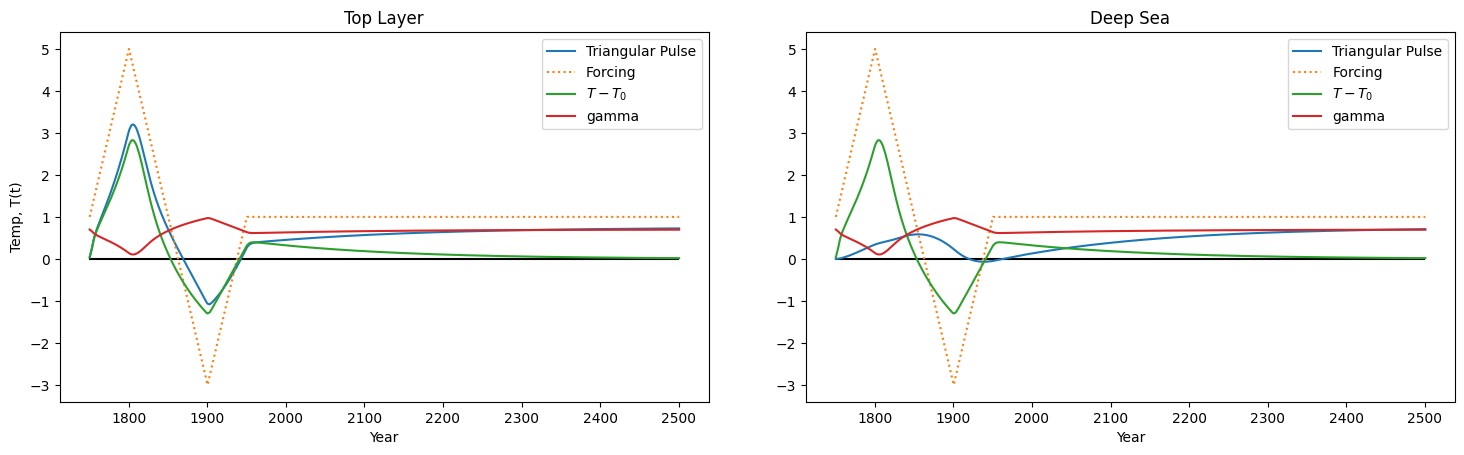

In [9]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = runs.keys()
run_outputs = runs.values()

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
        subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        subpl.plot(run.time[::3], run.gammas, label = "gamma") #The 3 is there to match the timestep
        subpl.hlines(0, 1750, 2500, 'k')
    
    
for subpl in axs:
     
    subpl.legend()

In [13]:
for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= step,
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        kappa=0, 
        outtime=np.arange(1750.5,2501),
        dt=3
    )
        
    out0 = scm.run()
runs["Kappa = 0, Triangular Pulse"] = out0


100%|██████████| 1000/1000 [00:21<00:00, 45.99it/s]


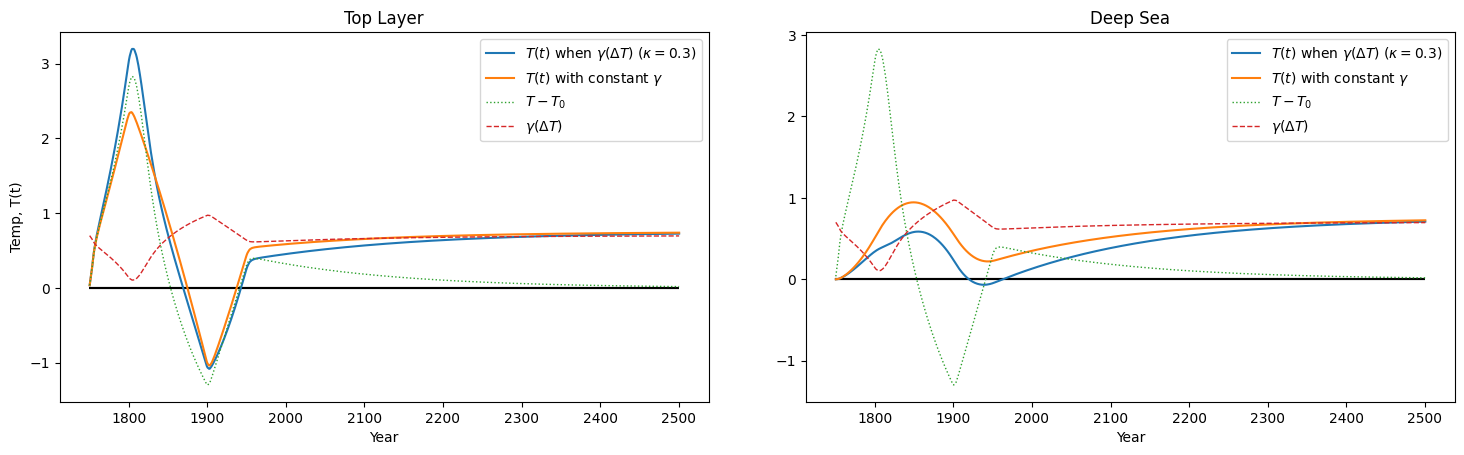

In [27]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = runs.keys()
run_outputs = runs.values()

layers = ["Top Layer", "Deep Sea"]
labels = ["$T(t)$ when $\gamma (\Delta T)$ ($\kappa = 0.3$)", "$T(t)$ with constant $\gamma$"]

for (run, label) in zip (run_outputs, labels):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = label)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = label)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        #subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
        
        
        subpl.hlines(0, 1750, 2500, 'k')
    
    
for subpl in axs:
    out1  = runs["Triangular Pulse"]
    subpl.plot(out1.time, (out1.tg- out1.tlev[:,1]), label = "$T-T_0$", linestyle = "dotted", linewidth = 1)
    subpl.plot(out1.time[::3], out1.gammas, label = "$\gamma (\Delta T)$",linestyle = "dashed", linewidth = 1) #The 3 is there to match the timestep
    subpl.legend()

Is this what we expect? Positive temperature difference corresponds to a gamma smaller than $\gamma_0$. This means that heat transfer is smaller, as stability increases. A negative $\Delta T$ then corresponds to $\gamma > \gamma_0$ -  decreasing stability. Increased stability, $\gamma < \gamma_0$, when warming of top layer is occuring, should mean that the effect of a non-constant gamma results in decreased warming of bottom layer, something which is indeed reproduced.  

## 2) Top hat forcing of widths 5,50,200 years 
Again, kappa = 0.3

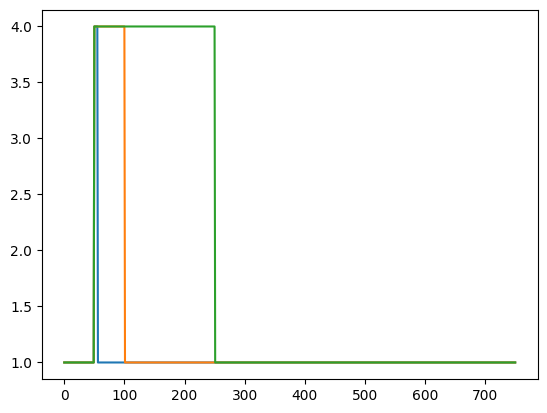

In [3]:
#Making top hat signals.

widths = [5,50,200]
tophat_signals = {}
for w in widths:
    sig = np.ones(751)
    sig[50:51+w] = 4
    tophat_signals[w] = sig
    plt.plot(sig)



In [12]:

for sig in tophat_signals:
    print(f"currently on tophat of width: %s... "%sig)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= tophat_signals[sig],
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            kappa=0.3, 
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    
    runs[f"TopHat Pulse width %s" %sig] = out


currently on tophat of width: 5... 


100%|██████████| 1000/1000 [00:24<00:00, 41.20it/s]


currently on tophat of width: 50... 


100%|██████████| 1000/1000 [00:24<00:00, 41.36it/s]


currently on tophat of width: 200... 


100%|██████████| 1000/1000 [00:29<00:00, 34.38it/s]


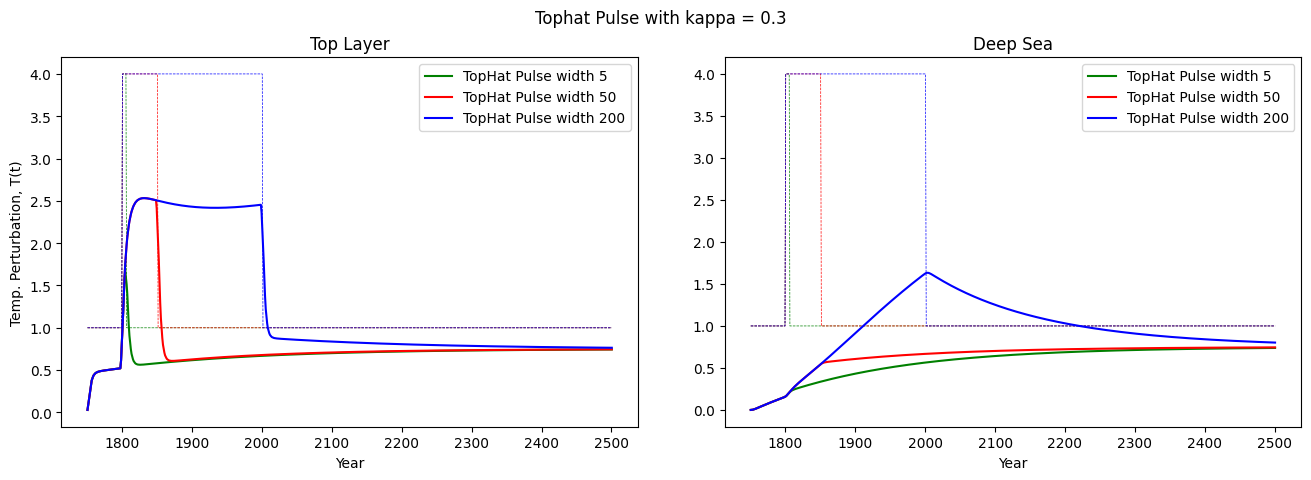

In [14]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')

fig.suptitle("Tophat Pulse with kappa = 0.3")

scenario_names = []
for w in widths: 
    scenario_names.append(f"TopHat Pulse width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, tophat_signals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, tophat_signals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    
    
for subpl in axs:
     
    subpl.legend()

$\Delta T$ increases, gamma decreases. Which mean bottom layer warms less than top layer. The top layer then heats more due to reduced flux. The bottom layer then warms and $\Delta T$ decreases, gamma increases, energy flows out of top layer. 



Compare with when kappa = 0
![Wow can't believe this works]( ./TopHatPulsesConstGamma.png "Aliasing")

Once again, the 5-year pulse is very short and illicits a very small deep see response. 

The obvious difference is in the 200 pulse. It no longer monotonically increaes during the 4xCO2 forcing. As the top layer temperature increases and $\Delta T$ increases, stability decreases, causing the heat flux to increases. This type of self-restoring behaviour makes me wonder whether we will see SHO behaviour with constant forcing... Let's see.  If so, could we end up with resonance behaviour??

### Constant forcing -> Investigating SHO behaviour
kappa = 0.3

Text(0.5, 1.0, 'Constant 4xCO2 forcing')

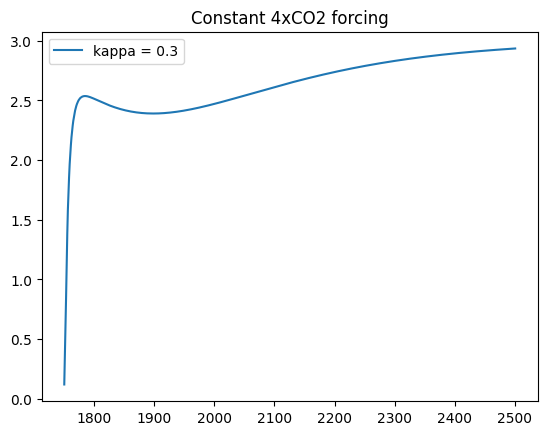

In [88]:
run = runs["Constant 4xCO2 forcing"]
plt.plot(run.time, run.tg, label = "kappa = 0.3")
plt.legend()
plt.title("Constant 4xCO2 forcing")


# Investigating different magnitudes of Kappa
with constant 4xCO2 forcing

In [33]:
kappas = [0,0.0001,0.001, 0.01, 0.1]

for k in kappas:    
    print(f"currently on kappa %s " %k)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= 4 * np.ones(751),
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            kappa=k, 
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    
    runs[f"Constant 4xCO2 forcing, kappa: %s" %k] = out


currently on kappa 0 


100%|██████████| 1000/1000 [00:22<00:00, 45.22it/s]


currently on kappa 0.0001 


100%|██████████| 1000/1000 [00:21<00:00, 45.65it/s]


currently on kappa 0.001 


100%|██████████| 1000/1000 [00:21<00:00, 46.62it/s]


currently on kappa 0.01 


100%|██████████| 1000/1000 [00:21<00:00, 46.19it/s]


currently on kappa 0.1 


100%|██████████| 1000/1000 [00:25<00:00, 38.47it/s]


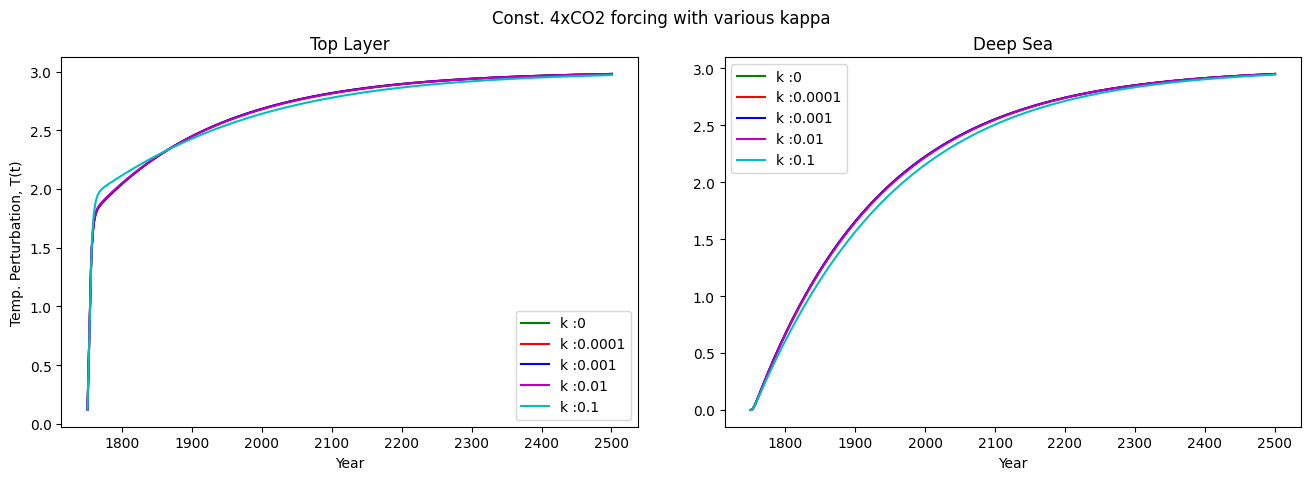

In [46]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')

fig.suptitle("Const. 4xCO2 forcing with various kappa")
#print(runs)

scenario_names = []
for k in kappas:
    scenario_names.append(f"Constant 4xCO2 forcing, kappa: %s" %k)
#print(scenario_names)

run_outputs = [runs.get(key) for key in scenario_names]
#print(run_outputs)

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b", "m", "c"]

for (run, scen, color, k) in zip (run_outputs, scenario_names, colors, kappas):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = f"k :%s"%k, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = f"k :%s"%k, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        #subpl.plot(run.time, 4* np.ones(751), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    
    
for subpl in axs:
     
    subpl.legend()

The effect of the first 4 values, [0, 0.01], seem qualitatively quite similar. The end value also doesn't seem to be affected much. But if we look at kappa = 0.3(see above), we see that there is an extremum, no longer does the temperature of both layers increase monotonically. Let's see when this extremum occurs...
But first, let's zoom in a bit:

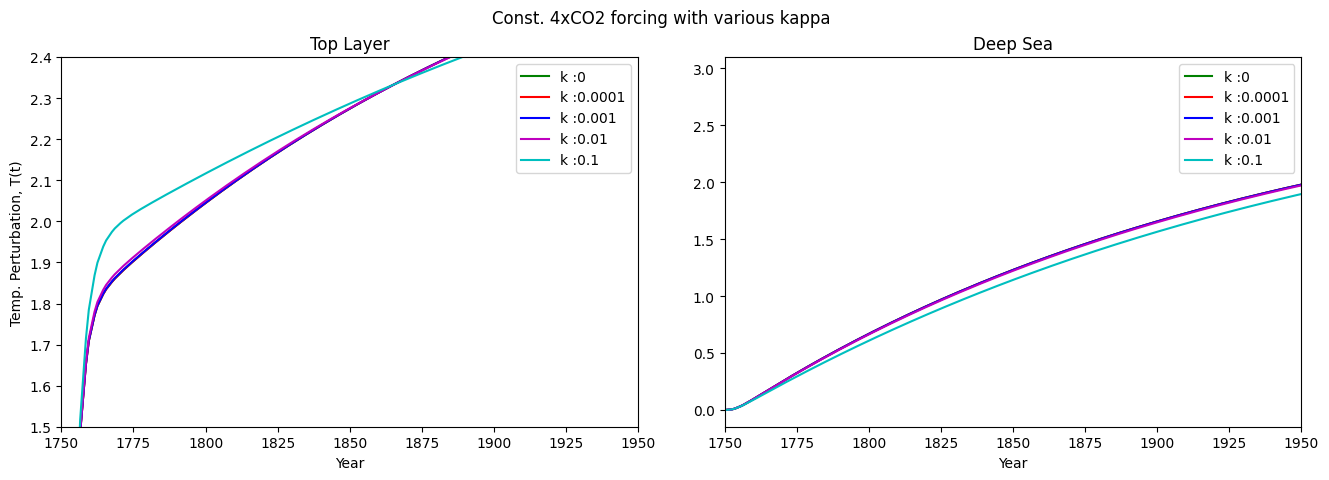

In [54]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')

fig.suptitle("Const. 4xCO2 forcing with various kappa")
#print(runs)

scenario_names = []
for k in kappas:
    scenario_names.append(f"Constant 4xCO2 forcing, kappa: %s" %k)
#print(scenario_names)

run_outputs = [runs.get(key) for key in scenario_names]
#print(run_outputs)

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b", "m", "c"]

for (run, scen, color, k) in zip (run_outputs, scenario_names, colors, kappas):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.set_ylim(1.5, 2.4)
            subpl.plot(run.time, run.tg, label = f"k :%s"%k, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = f"k :%s"%k, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.set_xlim(1750, 1950)
        
        #subpl.plot(run.time, 4* np.ones(751), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    
    
for subpl in axs:
     
    subpl.legend()

Zooming in has not been super insightful, let's move on to looking at the what happens in the range $\kappa \epsilon [0.1, 0.3]$

In [10]:
kappas_2 = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

for k in kappas_2:    
    print(f"currently on kappa %s " %k)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= 4 * np.ones(751),
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            kappa=k, 
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    
    runs[f"Constant 4xCO2 forcing, kappa: %s" %k] = out


currently on kappa 0.1 


100%|██████████| 1000/1000 [00:23<00:00, 42.47it/s]


currently on kappa 0.15 


100%|██████████| 1000/1000 [00:21<00:00, 47.42it/s]


currently on kappa 0.2 


100%|██████████| 1000/1000 [00:24<00:00, 40.33it/s]


currently on kappa 0.25 


100%|██████████| 1000/1000 [00:21<00:00, 45.82it/s]


currently on kappa 0.3 


100%|██████████| 1000/1000 [00:21<00:00, 45.52it/s]


currently on kappa 0.35 


100%|██████████| 1000/1000 [00:21<00:00, 46.53it/s]


I didn't expect kappa = 0.35 to work. Let's try 0.4...

In [9]:
#kappas_2 = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

#for k in kappas_2:    
print(f"currently on kappa 0.4")
for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= 4 * np.ones(751),
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        kappa=0.4, 
        outtime=np.arange(1750.5,2501),
        dt=3
    )
        
    out = scm.run()
    
runs[f"Constant 4xCO2 forcing, kappa: 0.4"] = out


currently on kappa 0.4


 46%|████▌     | 460/1000 [00:10<00:12, 43.26it/s]


KeyboardInterrupt: 

kappa = 0.4 is too big.

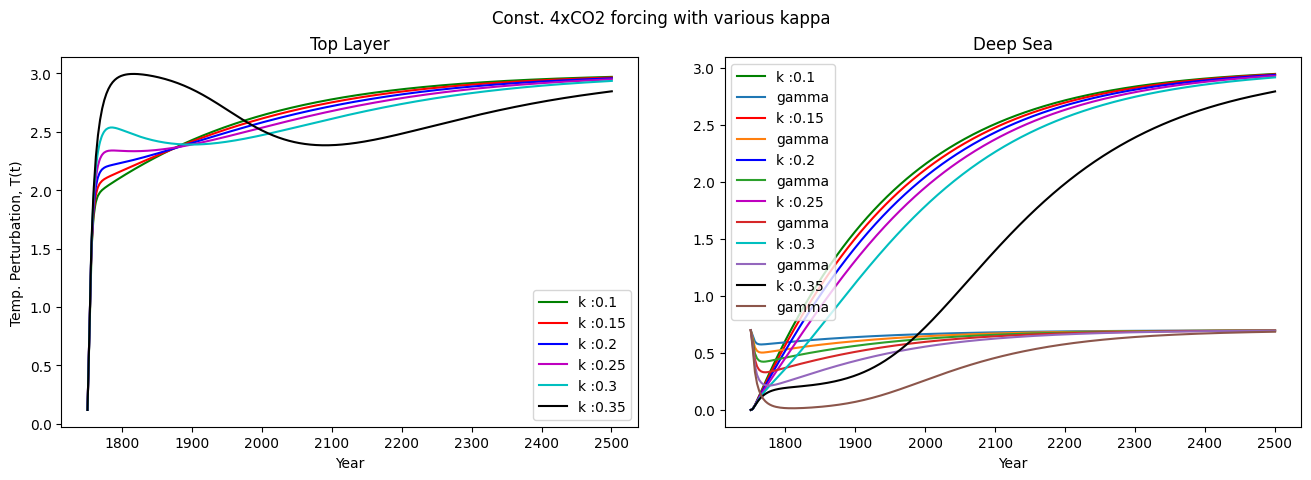

In [15]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')

fig.suptitle("Const. 4xCO2 forcing with various kappa")
#print(runs)

scenario_names = []
for k in kappas_2:
    scenario_names.append(f"Constant 4xCO2 forcing, kappa: %s" %k)
#print(scenario_names)

run_outputs = [runs.get(key) for key in scenario_names]
#print(run_outputs)

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b", "m", "c", "k"]

for (run, scen, color, k) in zip (run_outputs, scenario_names, colors, kappas_2):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = f"k :%s"%k, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = f"k :%s"%k, color = color)
            subpl.plot(run.time[::3], run.gammas, label ="gamma")
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        #subpl.plot(run.time, 4* np.ones(751), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        
    
    
for subpl in axs:
     
    subpl.legend()

The behaviour changes a lot more when we increase kappa from 0.3-0.35 than between the other values. Why? It isn't a linear relationship. Can we quantify this? Even without an analytical solution? ... Let's look at our previous investigation of varying gamma with kappa = 0 and see if that showed a linear relationship (It shouldn't have from what I see in the analytical solution where gamma is not linearly related to T or T_0)

Interesting is how much the behaviour differs fro k = 0.35. Looking at the bottom layer, we suddenly get a significant decrease in the slope. 

kappa = 0.35 seems like it would be a better candidate for investigating SHO behaviour. The whole system is like a (critically) damped SHO. Normally you wouldn't be changing the spring constant to reach resonance though... Now let's look at some oscillatory forcing. 

In [61]:
gammas = [1, 3, 5, 7, 9] #we just want something linearly spaced

for g in gammas:    
    print(f"currently on gamma %s " %g)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= 4 * np.ones(751),
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=g,
            kappa=0, 
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    
    runs[f"Constant 4xCO2 forcing, gamma: %s" %g] = out

currently on gamma 1 


100%|██████████| 1000/1000 [00:32<00:00, 30.31it/s]


currently on gamma 3 


100%|██████████| 1000/1000 [00:25<00:00, 38.75it/s]


currently on gamma 5 


100%|██████████| 1000/1000 [00:24<00:00, 41.00it/s]


currently on gamma 7 


100%|██████████| 1000/1000 [00:22<00:00, 45.44it/s]


currently on gamma 9 


100%|██████████| 1000/1000 [00:21<00:00, 45.47it/s]


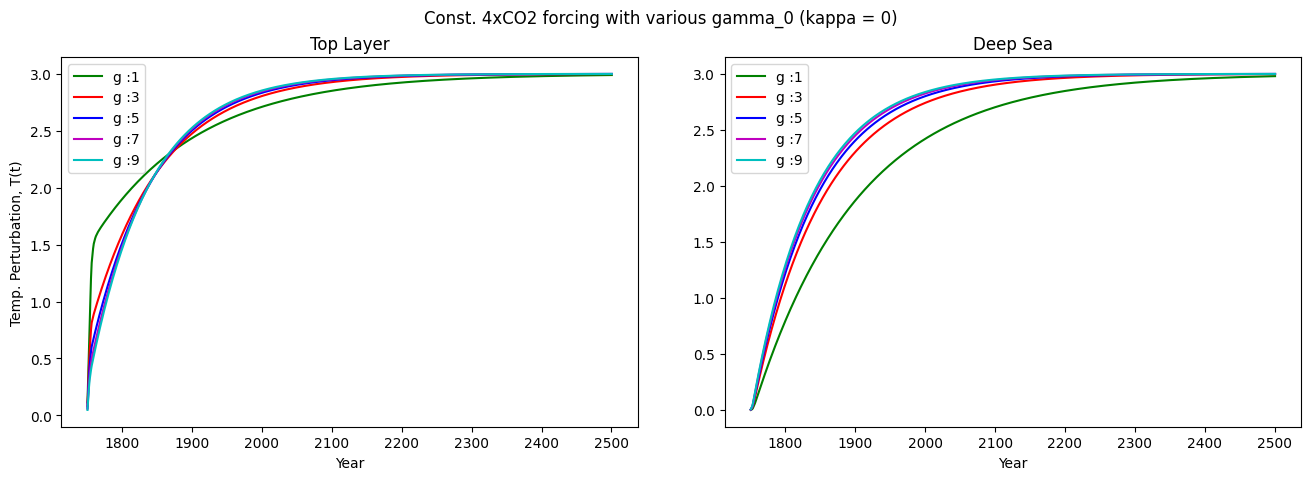

In [62]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')

fig.suptitle("Const. 4xCO2 forcing with various gamma_0 (kappa = 0)")
#print(runs)

scenario_names = []
for g in gammas:
    scenario_names.append(f"Constant 4xCO2 forcing, gamma: %s" %g)
#print(scenario_names)

run_outputs = [runs.get(key) for key in scenario_names]
#print(run_outputs)

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b", "m", "c"]

for (run, scen, color, g) in zip (run_outputs, scenario_names, colors, gammas):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = f"g :%s"%g, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = f"g :%s"%g, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        #subpl.plot(run.time, 4* np.ones(751), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    
    
for subpl in axs:
     
    subpl.legend()

..This has just confirmed the non-linear dependence on gamma. We aren't much closer to quantifying the dependence on kappa.

## 4)oscillatory tophat forcing of widths 5,50,200 years 

Still working with kappa = 0.3

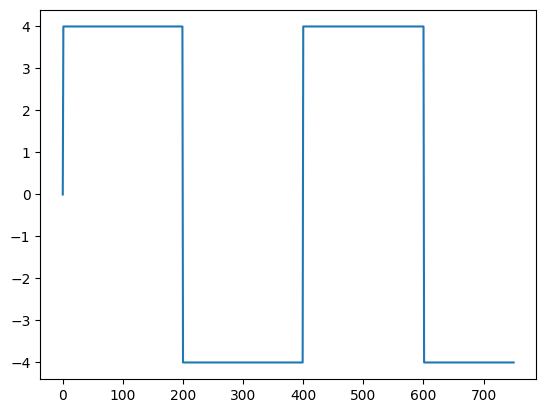

In [63]:
#Making oscillatory top hat signals.

widths = [5,50,200]
th_persignals = {}
for w in widths:

    xs = np.arange(751) 
    xs = 4*np.sign(np.sin(2*np.pi/(2*w) * xs))

    th_persignals[w] = xs
    #plt.plot(xs)
plt.plot(th_persignals[200])

In [73]:
for sig in th_persignals:
    print(f"currently on periodic tophat of width: %s... "%sig)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= th_persignals[sig],
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            kappa = 0.25,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=3
        )

        out = scm.run()
    runs[f"Periodic tophat width %s" %sig] = out

currently on periodic tophat of width: 5... 


100%|██████████| 1000/1000 [00:30<00:00, 32.40it/s]


currently on periodic tophat of width: 50... 


100%|██████████| 1000/1000 [00:23<00:00, 43.32it/s]


currently on periodic tophat of width: 200... 


100%|██████████| 1000/1000 [00:23<00:00, 43.16it/s]


We're already getting errors... I'm guessing gamma is going negative. From this we learn that: 

### **The maximum value of kappa depends on the forcing scenario!**

We will use a smaller kappa of k = 0.25 and try again.

We should add an error that catches when gamma goes negative.

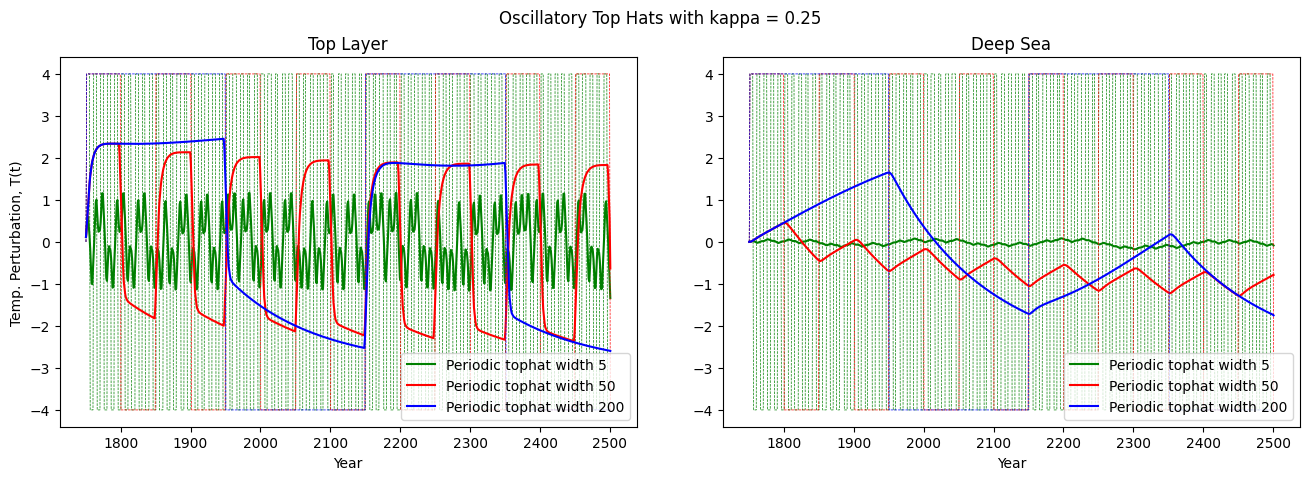

In [79]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')
fig.suptitle("Oscillatory Top Hats with kappa = 0.25")

widths = [5,50,200]

scenario_names = []
for w in widths: 
    scenario_names.append(f"Periodic tophat width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, th_persignals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
    
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, th_persignals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        
    
    
for subpl in axs:
     
    subpl.legend(loc="lower right")

Interesting! There is asymmetry between the positive and negative forcing !! This is what we were hoping to see! (Still need to replicate Bouttes though). What is happening with the deep sea temperature? Will it just continue to have its equilibrium drift downwards as it cools so much more efficiently than it warms? Is this what would happen in the absence of forcing? No, because when equilibrium is reaches ($\Delta T =0$), the cooling does does stop.

## 5)   oscillatory triangular forcing of widths 5,50,200 years 

kappa = 0.3 (try first and then adjust)

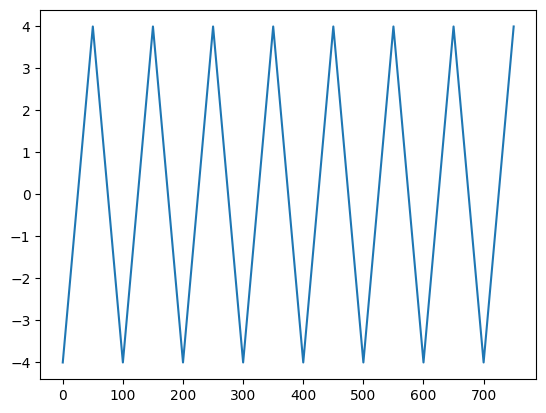

In [77]:
#Making oscillatory top hat signals.
from scipy import signal


#plt.plot(xs, 4*signal.sawtooth(xs, width = 0.5))

widths = [5,50,200]
tri_persignals = {}
for w in widths:

    xs = np.arange(751) 
    xs = 4*signal.sawtooth(2*np.pi/(2*w) * xs, width = 0.5)
    tri_persignals[w] = xs
    
plt.plot(tri_persignals[50])

In [78]:
for sig in tri_persignals:
    print(f"currently on periodic triangle of width: %s... "%sig)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= tri_persignals[sig],
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            kappa = 0.3,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=2
        )

        out = scm.run()
    runs[f"Periodic triangle width %s" %sig] = out

currently on periodic triangle of width: 5... 


100%|██████████| 1000/1000 [00:47<00:00, 20.94it/s]


currently on periodic triangle of width: 50... 


100%|██████████| 1000/1000 [00:35<00:00, 28.34it/s]


currently on periodic triangle of width: 200... 


100%|██████████| 1000/1000 [00:32<00:00, 30.85it/s]


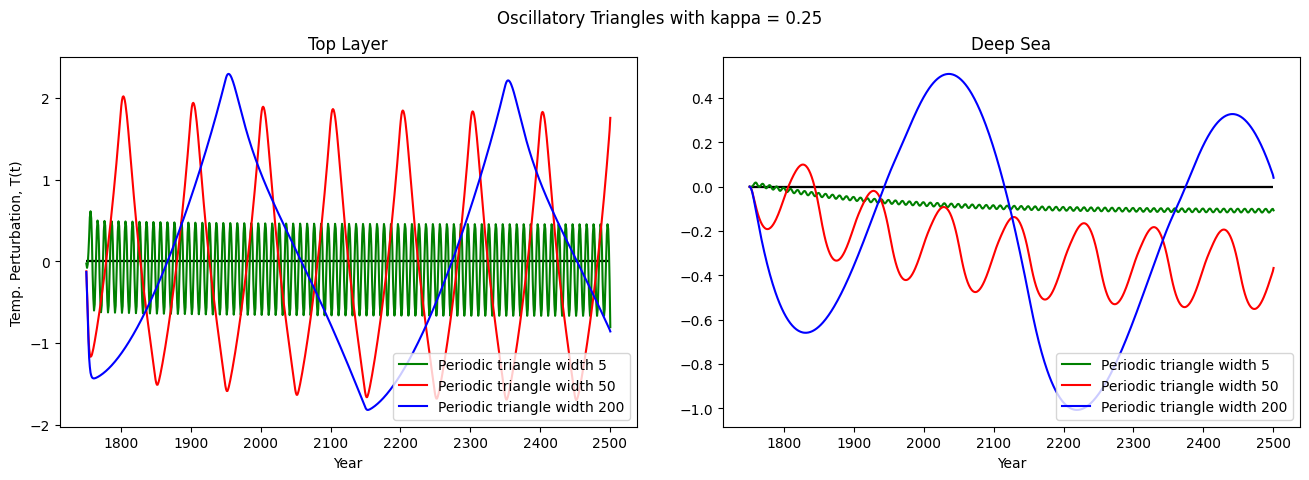

In [87]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')
fig.suptitle("Oscillatory Triangles with kappa = 0.25")

widths = [5,50,200]

scenario_names = []
for w in widths: 
    scenario_names.append(f"Periodic triangle width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, th_persignals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.hlines(0, 1750, 2500)
        #subpl.plot(run.time, th_persignals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        
    
    
for subpl in axs:
     
    subpl.legend(loc="lower right")

Think about this - The equilibrium looks like it's drifting, but will it stabilize? From what we can see with w=5 it looks like it does. We discussed this in the meeting -> Write down.

# Gamma threshold Testing
We have implemented the threshold to stop gamma from becoming negative. This should mean that there is no max value of kappa... Let's test this. 

In [3]:
runs = {}

In [26]:
kappas = [0,0.5,1]

for k in kappas:    
    print(f"currently on kappa %s " %k)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= 4 * np.ones(751),
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            kappa=k, 
            outtime=np.arange(1750.5,2501),
            dt=1
        )
        
        out = scm.run()
    
    runs[f"Constant 4xCO2 forcing, kappa: %s" %k] = out

currently on kappa 0 


100%|██████████| 1000/1000 [01:03<00:00, 15.66it/s]


currently on kappa 0.5 


100%|██████████| 1000/1000 [00:59<00:00, 16.87it/s]


currently on kappa 1 


100%|██████████| 1000/1000 [01:09<00:00, 14.38it/s]


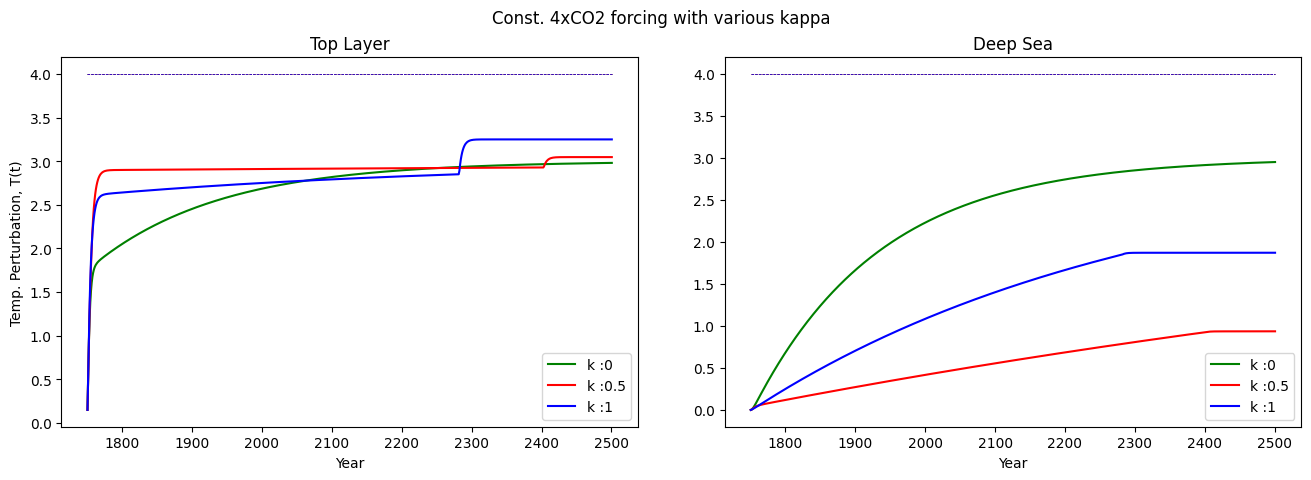

In [27]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')

fig.suptitle("Const. 4xCO2 forcing with various kappa")
#print(runs)

scenario_names = []
for k in kappas:
    scenario_names.append(f"Constant 4xCO2 forcing, kappa: %s" %k)
#print(scenario_names)

run_outputs = [runs.get(key) for key in scenario_names]
#print(run_outputs)

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b", "m", "c"]

for (run, scen, color, k) in zip (run_outputs, scenario_names, colors, kappas):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = f"k :%s"%k, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = f"k :%s"%k, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, 4* np.ones(751), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    
    
for subpl in axs:
     
    subpl.legend()

This looks very strange. Maybe this is why we'd want a min value of gamma/gamma_0.. But what is actually happening?
Let's plot only k=1 and the gamma evolution and see...

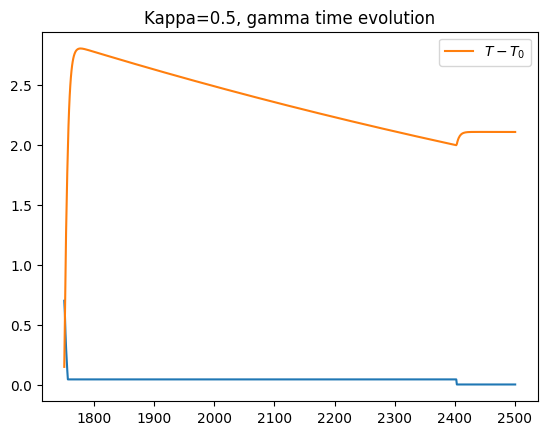

In [29]:
run1 = runs["Constant 4xCO2 forcing, kappa: 0.5"]
#plt.plot(run1.time, run1.tg)
plt.plot(run1.time, run1.gammas)
plt.title("Kappa=0.5, gamma time evolution")
plt.plot(run1.time,(run1.tg- run1.tlev[:,1]), label = "$T-T_0$")
#plt.ylim(0,0.3)
plt.legend()

Why is the $\Delta T$ changing but gamma is staying constant? This is happening because gamma_new would still be zero or smaller I think. It would be nice to know whats happening at the step though..

In [ ]:
#print(run1.gammas)
step_index = run1.gammas.index(0.002815363529195558)
print(step_index)
print((run.tg- run.tlev[:,1])[step_index*3-1], (run.tg- run.tlev[:,1])[step_index*3], (run.tg- run.tlev[:,1])[step_index*3+1])
print(0.5*(run.tg- run.tlev[:,1])[step_index*3])

print(len(run1.tg))
print(len(run1.gammas))

#plt.plot(run1.time, run1.tg)
plt.plot(run1.time[::3], run1.gammas)
plt.title("Kappa=0.5, gamma time evolution")
plt.plot(run1.time,(run1.tg- run1.tlev[:,1]), label = "$T-T_0$")
#plt.ylim(0,0.3)

plt.scatter(run1.time[step_index*3], (run1.tg- run1.tlev[:,1])[step_index*3])
plt.plot(run1.time,0.7*(1-0.5*(run1.tg- run1.tlev[:,1])), label = "gamma before threshold")


plt.legend()

Something is definitley not working with the threshold... Actually nvm, I think it is working.

We get adrupt changes in gamma when we get adrupt changes in $\Delta T$. But why is that happening??? The forcing is supposedly constant?

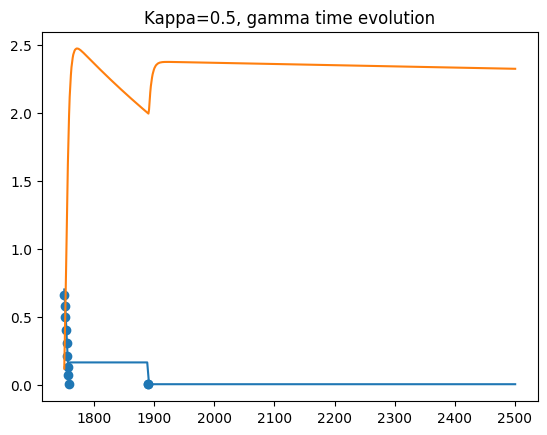

In [25]:
#we expect gamma to be limited at indices:

inds = np.where(0.7*(1-0.5*(run1.tg- run1.tlev[:,1])) > 0)
#print(0.7*(1-0.5*(run1.tg- run1.tlev[:,1]))[inds])

#plt.plot(run1.time, run1.tg)
plt.plot(run1.time[::3], run1.gammas,label="gammas")
plt.title("Kappa=0.5, gamma time evolution")
plt.plot(run1.time,(run1.tg- run1.tlev[:,1]), label = "$T-T_0$")
plt.scatter(run1.time[inds],0.7*(1-0.5*(run1.tg- run1.tlev[:,1]))[inds])
plt.legend()


So the threshold is doing what it's supposed to do, it follows the original definition of $\gamma = \gamma_0(1-\kappa * \Delta T)$ until this become negative, at which the previous value is then just maintained. The problem is that this leads to discontinuous jumps in gamma when $\gamma = \gamma_0(1-\kappa * \Delta T)$ becomes positive again. How do we fix this?

I think the values of gamma that appear to have been ignored are due to gamma only being calculated ever 3 years, in accordance with the time step.

What's weird is honestly the second change in gamma. From the analysis, you'd think that gamma should stay negative as 


I think the problem is the timestep! It must be small enough that we get $\gamma$ as close to zero as possible. Once this happens and we are looking at constant forcing, gamma will remain unchanged at $\Delta T$ only continues to grow. 

Now, what if the forcing does suddenly change sign?


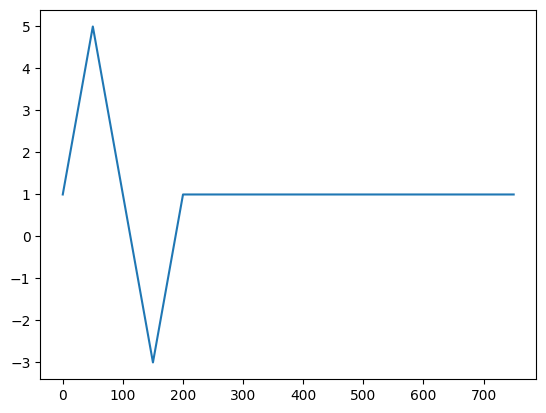

In [2]:
runs = {}

xs = np.arange(751) 
xs = xs * 4/50

xs[50:151] = xs[50:151]* -1

xs[50:151] = xs[50:151] + 8 
xs[151:201] = xs[151:201] - 16
xs += 1
xs[200:] = 1

triang_pulse = xs
plt.plot(xs)
#need to run cell above
steps = [triang_pulse]
step_names = ["Triangular Pulse"]




In [38]:
for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= triang_pulse,
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        kappa=5, 
        outtime=np.arange(1750.5,2501),
        dt=1
    )
        
    out0 = scm.run()
runs["Kappa = 5, Triangular Pulse"] = out0



100%|██████████| 1000/1000 [01:20<00:00, 12.47it/s]


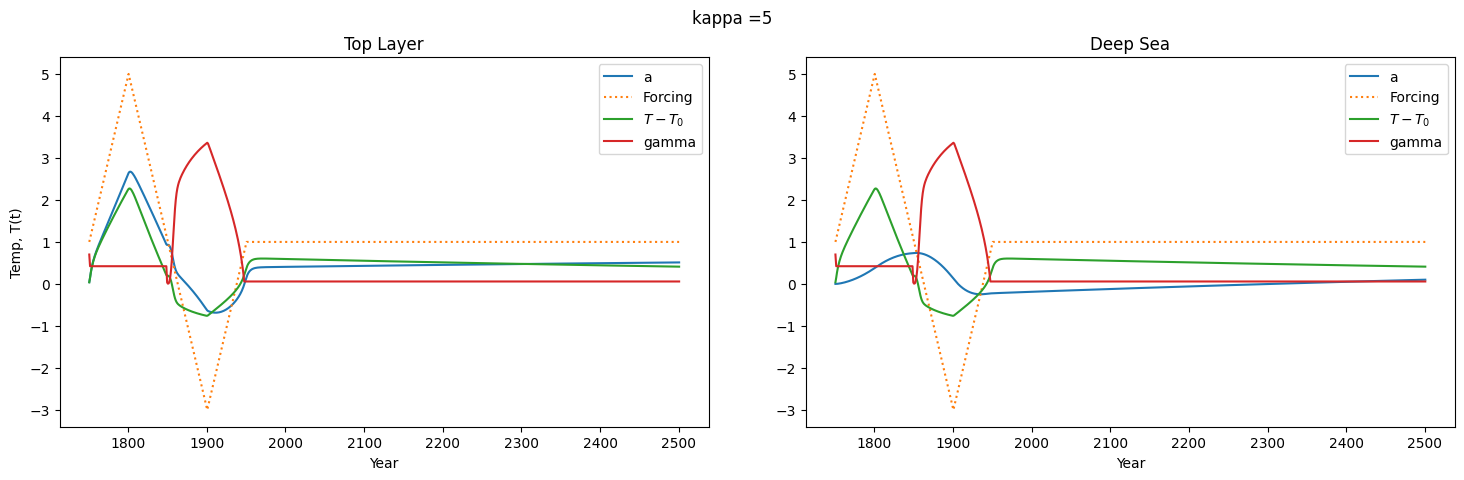

In [50]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');
fig.suptitle("kappa =5 ")


scenario_names = "Kappa = 5, Triangular Pulse"
run = runs["Kappa = 5, Triangular Pulse"]

layers = ["Top Layer", "Deep Sea"]


for (subpl, col, layer) in zip(axs, [0,1], layers):
    if col == 0:
        subpl.plot(run.time, run.tg, label = scen)
    else:
         subpl.plot(run.time, run.tlev[:,1], label = scen)
    subpl.title.set_text(layer)
    subpl.set_xlabel('Year')
    subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
    subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    subpl.plot(run.time, run.gammas, label = "gamma") #The 3 is there to match the timestep
    #subpl.hlines(5, 1750, 2500, 'k')
    
    
for subpl in axs:
     
    subpl.legend()

I don't like the sudden jumps in gamma.. Of course this is also due to the large kappa... So we have to be careful not to use too large values of kappa and small timesteps.

In [5]:
for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= triang_pulse,
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        kappa=1, 
        outtime=np.arange(1750.5,2501),
        dt=1
    )
        
    out0 = scm.run()
runs["Kappa = 1, Triangular Pulse"] = out0


  8%|▊         | 79/1000 [00:06<01:20, 11.45it/s]


KeyboardInterrupt: 

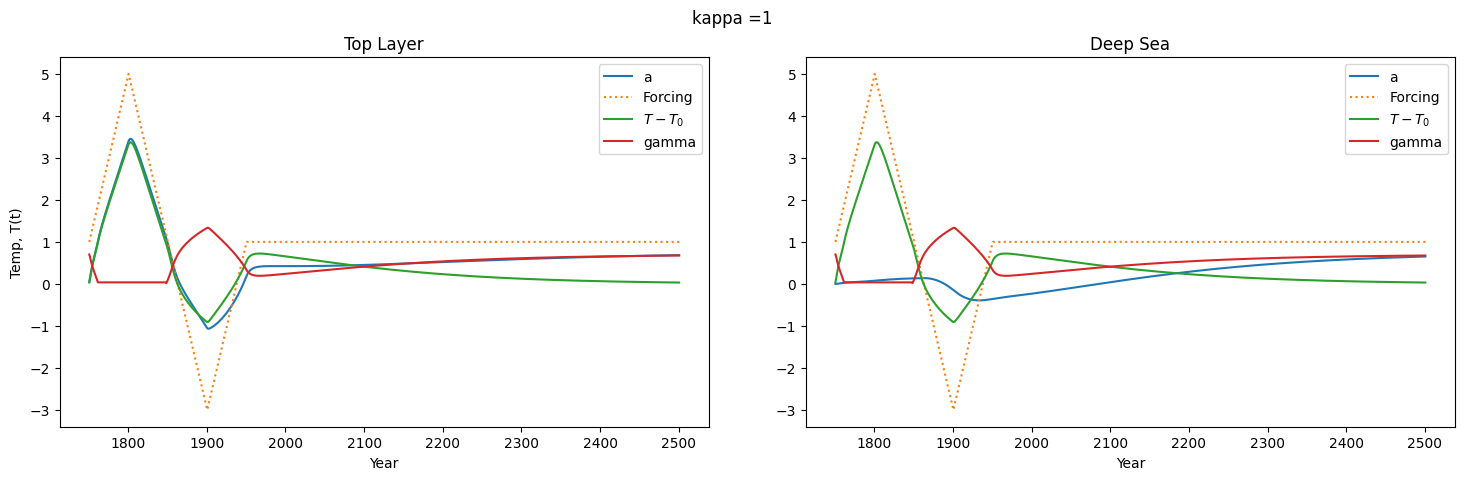

In [49]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)')
fig.suptitle("kappa =1 ")


scenario_names = "Kappa = 1, Triangular Pulse"
run = runs["Kappa = 1, Triangular Pulse"]

layers = ["Top Layer", "Deep Sea"]


for (subpl, col, layer) in zip(axs, [0,1], layers):
    if col == 0:
        subpl.plot(run.time, run.tg, label = scen)
    else:
         subpl.plot(run.time, run.tlev[:,1], label = scen)
    subpl.title.set_text(layer)
    subpl.set_xlabel('Year')
    subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
    subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    subpl.plot(run.time, run.gammas, label = "gamma") #The 3 is there to match the timestep
    #subpl.hlines(5, 1750, 2500, 'k')

    
    
for subpl in axs:
     
    subpl.legend()

Definitely less problematic already..

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

In [4]:
for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= triang_pulse,
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        kappa=0.1, 
        outtime=np.arange(1750.5,2501),
        dt=1
    )
        
    out0 = scm.run()
runs["Kappa = 1, Triangular Pulse with sigma = 0.5"] = out0

100%|██████████| 1000/1000 [01:06<00:00, 15.08it/s]


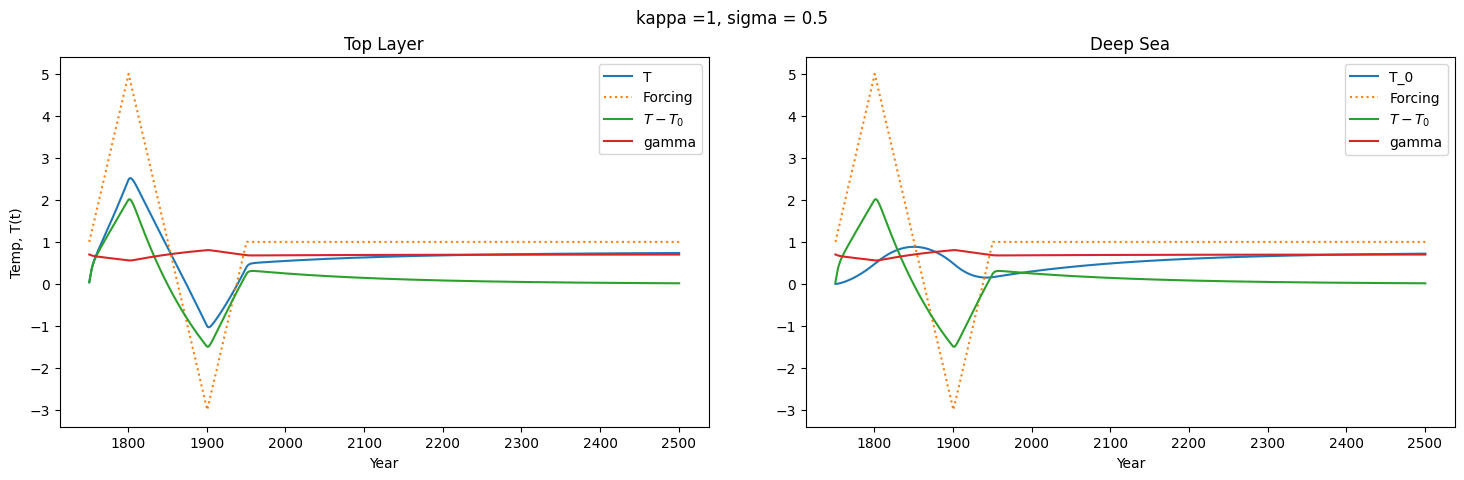

In [5]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');
fig.suptitle("kappa =1, sigma = 0.5 ")


scenario_names = "Kappa = 1, Triangular Pulse with sigma = 0.5"
run = runs["Kappa = 1, Triangular Pulse with sigma = 0.5"]

layers = ["Top Layer", "Deep Sea"]


for (subpl, col, layer) in zip(axs, [0,1], layers):
    if col == 0:
        subpl.plot(run.time, run.tg, label = "T")
    else:
         subpl.plot(run.time, run.tlev[:,1], label = "T_0")
    subpl.title.set_text(layer)
    subpl.set_xlabel('Year')
    subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
    subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    subpl.plot(run.time, run.gammas, label = "gamma") #The 3 is there to match the timestep
    #subpl.hlines(5, 1750, 2500, 'k')
    
    
for subpl in axs:
     
    subpl.legend()

I think the numpy.inf is ruining it...... 
But it also doesn't work when I add sigma = 0.5...

The problem is that ...What is the problem?

In [10]:
print(run.gammas)

[0.7, 0.6994432123628642, 0.6985325599705764, 0.6978356406825579, 0.6972856858871592, 0.6968369543403451, 0.696458082907804, 0.6961275530815224, 0.6958305933843649, 0.6955570596524512, 0.6952999829134724, 0.6950545738226341, 0.6948175397162524, 0.6945866159136084, 0.6943602439463612, 0.6941373505971007, 0.6939171961302025, 0.6936992700280867, 0.6934832193510899, 0.6932687995056276, 0.6930558404067314, 0.6928442232181099, 0.6926338643611237, 0.6924247045196739, 0.6922167010792216, 0.6920098229266982, 0.6918040468736678, 0.6915993551957156, 0.6913957339395006, 0.6911931717578141, 0.6909916591078488, 0.6907911876993531, 0.6905917501147161, 0.6903933395473689, 0.6901959496216097, 0.6899995742684747, 0.6898042076401915, 0.6896098440511966, 0.6894164779374379, 0.6892241038282743, 0.6890327163270501, 0.6888423100976452, 0.688652879855142, 0.688464420359326, 0.6882769264101462, 0.6880903928445196, 0.6879048145340655, 0.6877201863834831, 0.6875365033293674, 0.6873537603393364, 0.687171952411362